# Case Study: Recidivism

**Co-authors**
> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)
> - [Arnav Sood *UBC*](https://arnavsood.com)

**Prerequisites**

- {doc}`matplotlib Introduction <../pandas/matplotlib>`
- {doc}`Visualization Rules <visualization_rules>`
- {doc}`Regression <regression>`

**Outcomes**

- See an end-to-end data science exercise
- Application of regression


```{literalinclude} ../_static/colab_full.raw
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Introduction to Recidivism

Recidivism is the tendency for an individual who has previously committed a crime to commit another crime
in the future.

One key input to a judge's sentencing decision is how likely a given convict is to re-offend, or recidivate.

In an effort to assist the legal system with sentencing guidelines, data scientists have attempted
to predict an individual's risk of recidivism from known observables.

Some are concerned that this process may exhibit prejudice, either through biased inputs
or through statistical discrimination.

For example,

1. Biased inputs: Imagine that a judge often writes harsher sentences to people of a particular race or gender. If an algorithm is trained to reproduce the sentences of this judge, the bias will be propagated by the algorithm.
1. Statistical discrimination: Imagine that two variables (say race and income) are correlated, and one of them (say income) is correlated with the risk of recidivism. If income is unobserved, then an otherwise unbiased method would discriminate based on race, even if race has nothing to say about recidivism after controlling for income.

This has given rise to serious discussions about the moral obligations data scientists have to
those who are affected by their tools.

We will not take a stance today on our moral obligations, but we believe this is an important
precursor to any statistical work with public policy applications.

One predictive tool used by various courts in the United States is
called COMPAS (Correctional Offender Management Profiling for Alternative Sanctions).

We will be following a [Pro Publica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
article that analyzes the output of COMPAS.

The findings of the article include:

- Black defendants were often predicted to be at a higher risk of recidivism than they actually were.
- White defendants were often predicted to be less risky than they were.
- When controlling for prior crimes, future recidivism, age, and gender, black defendants were 45
  percent more likely to be assigned higher risk scores than white defendants.
- Black defendants were twice as likely as white defendants to be misclassified as being a higher
  risk of violent recidivism.
- Even when controlling for prior crimes, future recidivism, age, and gender, black defendants were
  77 percent more likely to be assigned higher risk scores than white defendants.

## Data Description

The authors of this article filed a public records request with the Broward County Sheriff's office
in Florida.

Luckily for us, they did a significant amount of the legwork which is described in this
[methodology article](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

We download the data below.

In [2]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis"
data_url += "/master/compas-scores-two-years.csv"

df = pd.read_csv(data_url)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


We summarize some of the variables that we will use.

- `first`: An individual's first name
- `last`: An individual's last name
- `sex`: An individual's sex
- `age`: An individual's age
- `race`: An individual's race. It takes values of Caucasian, Hispanic, African-American, Native American, Asian, or Other
- `priors_count`: Number of previous arrests
- `decile_score`: The COMPAS risk score
- `two_year_recid`: Whether the individual had been jailed for a new crime in next two years

## Descriptive Statistics

The first thing we do with our data is to drop any classes without "enough" observations.

One of our focuses will be on inter-race differences in scores and recidivism, so we only
keep data on races with at least 500 observations in our data set.

Just be aware that this kind of seemingly and even genuinely benign or "technical" decision can still perpetuate inequality by exclusion.

For example, Asians are a small minority, so they're not really present in the data, and therefore they're absent from the policy discussion --- we have no inferential knowledge on how COMPAS scores work for them.

In [3]:
race_count = df.groupby(["race"])["name"].count()
at_least_500 = list(race_count[race_count > 500].index)
print("The following race have at least 500 observations:", at_least_500)
df = df.loc[df["race"].isin(at_least_500), :]

The following race have at least 500 observations: ['African-American', 'Caucasian', 'Hispanic']


Next, we explore the remaining data using plots and tables.

### Age, Sex, and Race

Let's look at how the dataset is broken down into age, sex, and race.

In [4]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

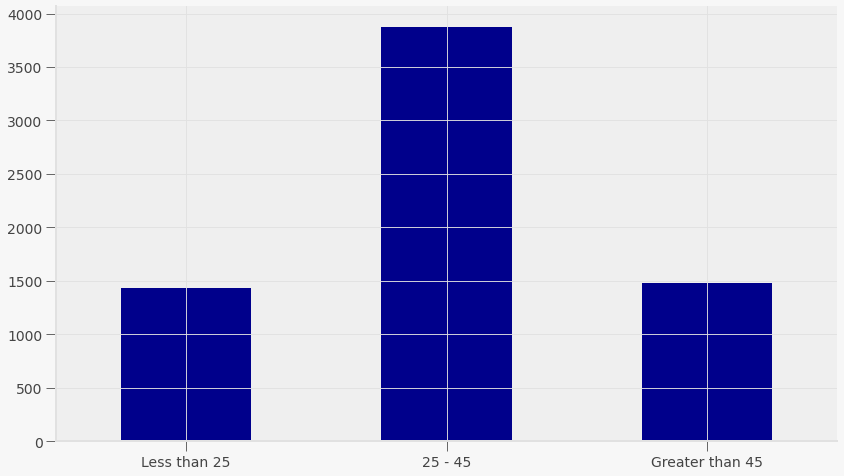

In [5]:
age_cs = ["Less than 25", "25 - 45", "Greater than 45"]
df["age_cat"] = pd.Categorical(df["age_cat"], categories=age_cs, ordered=True)
fig, ax = create_groupcount_barplot(df, "age_cat", (14, 8), color="DarkBlue", rot=0)

(<Figure size 432x576 with 1 Axes>, <AxesSubplot:>)

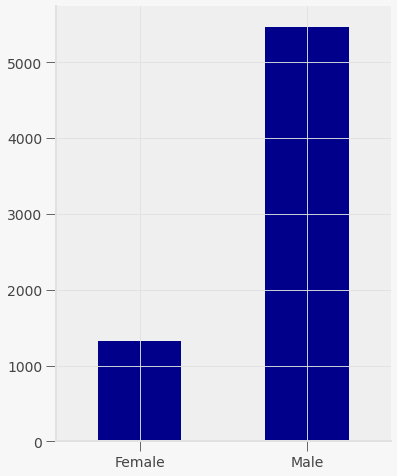

In [6]:
sex_cs = ["Female", "Male"]
df["sex"] = pd.Categorical(df["sex"], categories=sex_cs, ordered=True)
create_groupcount_barplot(df, "sex", (6, 8), color="DarkBlue", rot=0)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

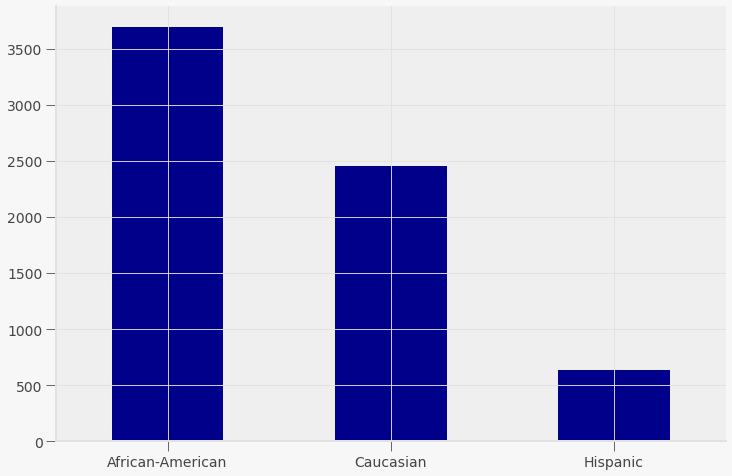

In [7]:
race_cs = ["African-American", "Caucasian", "Hispanic"]
df["race"] = pd.Categorical(df["race"], categories=race_cs, ordered=True)
create_groupcount_barplot(df, "race", (12, 8), color="DarkBlue", rot=0)

From this, we learn that our population is mostly between 25-45, male, and
is mostly African-American or Caucasian.

### Recidivism

We now look into how recidivism is split across groups.

In [8]:
recid = df.groupby(["age_cat", "sex", "race"])["two_year_recid"].mean().unstack(level="race")
recid

race                    African-American  Caucasian  Hispanic
age_cat         sex                                          
Less than 25    Female          0.449704   0.310345  0.411765
                Male            0.645806   0.541254  0.536364
25 - 45         Female          0.382278   0.423948  0.333333
                Male            0.533074   0.433699  0.375000
Greater than 45 Female          0.227273   0.239766  0.217391
                Male            0.425101   0.289157  0.216667

In the table, we see that the young have higher recidivism rates than the old, except for among
Caucasian females.

Also, African-American males are at a particularly high risk of recidivism even as they get older.

### Risk Scores

Each individual in the dataset was assigned a `decile_score` ranging from 1 to 10.

This score represents the perceived risk of recidivism with 1 being the lowest risk and 10 being the highest.

We show a bar plot of all decile scores below.

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

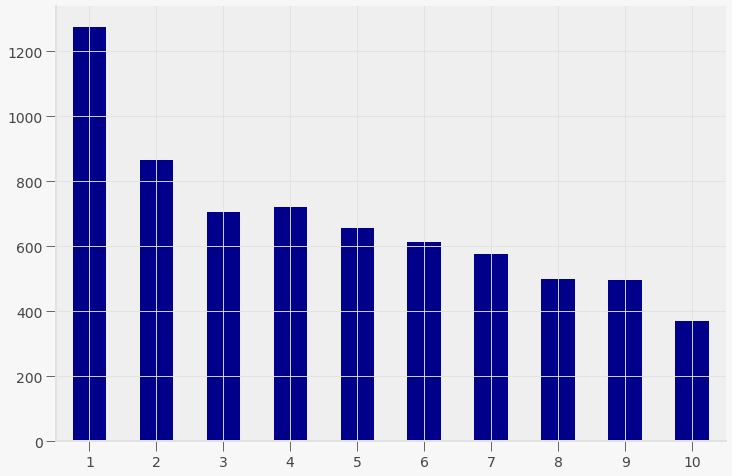

In [9]:
create_groupcount_barplot(df, "decile_score", (12, 8), color="DarkBlue", rot=0)

How do these scores differ by race?

Text(0.5, 0.98, 'Score Frequency by Race')

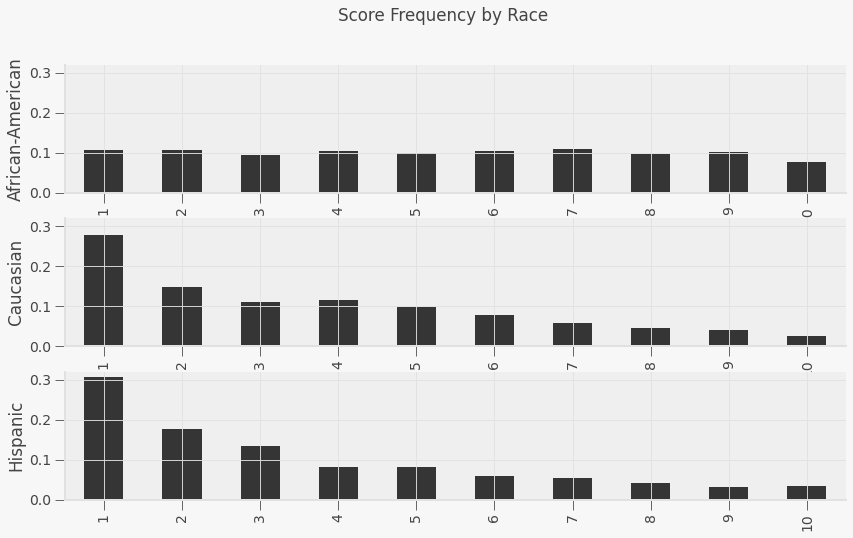

In [10]:
dfgb = df.groupby("race")
race_count = df.groupby("race")["name"].count()

fig, ax = plt.subplots(3, figsize=(14, 8))

for (i, race) in enumerate(["African-American", "Caucasian", "Hispanic"]):
    (
        (dfgb
            .get_group(race)
            .groupby("decile_score")["name"].count() / race_count[race]
        )
        .plot(kind="bar", ax=ax[i], color="#353535")
    )
    ax[i].set_ylabel(race)
    ax[i].set_xlabel("")
    # set equal y limit for visual comparison
    ax[i].set_ylim(0, 0.32)

fig.suptitle("Score Frequency by Race")

While Caucasians and Hispanics both see the majority of their score distribution on low values,
African-Americans are almost equally likely to receive any score.

### Risk Scores and Recidivism

Now we can explore the relationship between the risk score and actual two year recidivism.

The first measure we look at is the frequency of recidivism by decile score -- these numbers
tell us what percentage of people assigned a particular risk score committed a new crime within two
years of being released.

In [11]:
df.groupby("decile_score")["two_year_recid"].mean()

decile_score
1     0.220392
2     0.309112
3     0.375887
4     0.426593
5     0.478723
6     0.564228
7     0.590988
8     0.681363
9     0.698795
10    0.770889
Name: two_year_recid, dtype: float64

Let's also look at the correlation.

In [12]:
df[["decile_score", "two_year_recid"]].corr()

,decile_score,two_year_recid
decile_score,1.000000,0.346797
two_year_recid,0.346797,1.000000


As the risk score increases, the percentage of people committing a new crime does as well, with a
positive correlation (~0.35).

This is good news -- it means that the score is producing at least some signal about an individual's recidivism risk.

One of the key critiques from Pro Publica, though, was that the inaccuracies were nonuniform --- that is, the tool was systematically wrong about certain populations.

Let's now separate the correlations by race and see what happens.

In [13]:
recid_rates = df.pivot_table(index="decile_score", columns="race", values="two_year_recid")

recid_rates

race,African-American,Caucasian,Hispanic
decile_score,,,
1,0.228643,0.208517,0.244898
2,0.302799,0.313019,0.318584
3,0.419075,0.340659,0.313953
4,0.459740,0.396491,0.346154
5,0.482192,0.460581,0.538462
6,0.559896,0.572165,0.567568
7,0.592500,0.615385,0.470588
8,0.682451,0.719298,0.500000
9,0.707895,0.693878,0.550000


Or, in plotted form,

Text(0.5, 0.98, 'Recidivism Rates by Race')

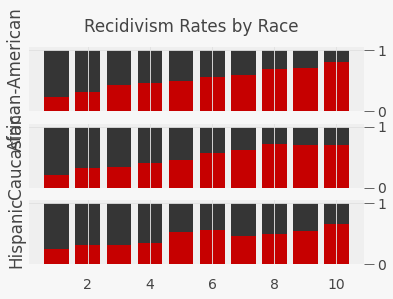

In [14]:
fig, ax = plt.subplots(3, sharex="all")

for (i, _race) in enumerate(["African-American", "Caucasian", "Hispanic"]):
    _rr_vals = recid_rates[_race].values

    ax[i].bar(np.arange(1, 11), _rr_vals, color="#c60000")
    ax[i].bar(np.arange(1, 11), 1 - _rr_vals, bottom=_rr_vals, color="#353535")
    ax[i].set_ylabel(_race)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].yaxis.tick_right()
    ax[i].xaxis.set_ticks_position("none")

fig.suptitle("Recidivism Rates by Race")

## Regression

In what follows, we will be doing something slightly different than what was done in the Pro Publica
article.

First, we will explore what happens when we try to predict the COMPAS risk scores using the
observable data that we have.

Second, we will use binary probability models to predict whether an individual is at risk of
recidivism.

We will do this first using the COMPAS risk scores, and then afterwards we will try to write our own
model based on raw observables, like age, race and sex.

### Preprocessing

We would like to use some features that are inherently non-numerical such as sex, age group, and
race in our model.

Before we can do that, we need to encode these string values as numerical values
so our machine learning algorithms can understand them -- an econometrician would call this,
creating dummy variables.

`sklearn` can automatically do this for us using `OneHotEncoder`.

Essentially, we make one column for each possible value of a categorical
variable and then we set just one of these columns equal to a 1 if the observation has that
column's category, and set all other columns to 0.

Let's do an example.

Imagine we have the array below.

In [15]:
sex = np.array([["Male"], ["Female"], ["Male"], ["Male"], ["Female"]])

The way to encode this would be to create the array below.

In [16]:
sex_encoded = np.array([
    [0.0, 1.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0],
    [1.0, 0.0]
])

Using `sklearn` it would be:

In [17]:
ohe = preprocessing.OneHotEncoder(sparse=False)
sex_ohe = ohe.fit_transform(sex)

# This should shows 0s!
sex_ohe - sex_encoded

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

We will use this encoding trick below as we create our data.

### Predicting COMPAS Scores

First, we proceed by creating the `X` and `y` inputs into a manageable format.

We encode the categorical variables using the `OneHotEncoder` described above, and then merge that with the non-categorical data.

Finally, we split the data into training and validation (test) subsets.

In [18]:
def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

As we proceed, our goal will be to see which variables are most important for predicting the COMPAS
scores.

As we estimate these models, one of our metrics for success will be mean absolute error (MAE).

In [19]:
def fit_and_report_maes(mod, X_train, X_test, y_train, y_test, y_transform=None, y_inv_transform=None):
    if y_transform is not None:
        mod.fit(X_train, y_transform(y_train))
    else:
        mod.fit(X_train, y_train)

    yhat_train = mod.predict(X_train)
    yhat_test = mod.predict(X_test)

    if y_transform is not None:
        yhat_train = y_inv_transform(yhat_train)
        yhat_test = y_inv_transform(yhat_test)

    return dict(
        mae_train=metrics.mean_absolute_error(y_train, yhat_train),
        mae_test=metrics.mean_absolute_error(y_test, yhat_test)
    )

Let's begin with a simple linear model which uses just prior arrests.

In [20]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], [], "decile_score"
)

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 2.162527833108664, 'mae_test': 2.191754484529134}

This simple model obtains a MAE of about 2 for both the test data and training data.

This means, on average, that our model can predict the COMPAS score (which ranges from 1-10)
within about 2 points.

While the MAE is about 2, knowing what the errors on our prediction model look
like is often very useful.

Below, we create a histogram which shows the distribution of these errors. In our case, we
take the difference between predicted value and actual value, so a positive value means that we
overpredicted the COMPAS score and a negative value means we underpredicted it.

Text(0.5, 1.0, 'Test Data')

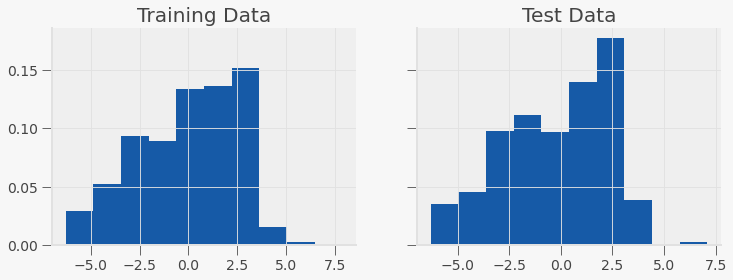

In [21]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

In both cases, the long left tails of errors suggest the existence of relevant features which would improve our model.

The first thing we might consider investigating is whether there are non-linearities in how the
number of priors enters the COMPAS score.

First, we try using polynomial features in our exogenous variables.

In [22]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], [], "decile_score"
)

# Transform data to quadratic
pf = preprocessing.PolynomialFeatures(2, include_bias=False)
X_train = pf.fit_transform(X_train)
X_test = pf.fit_transform(X_test)

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 2.120405801755292, 'mae_test': 2.1179838134597335}

We don't see a very significant increase in performance, so we also try using log on the endogenous
variables.

In [23]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], [], "decile_score"
)

fit_and_report_maes(
    linear_model.LinearRegression(), X_train, X_test, y_train, y_test,
    y_transform=np.log, y_inv_transform=np.exp
)

{'mae_train': 2.2550821558610115, 'mae_test': 2.3332184125647917}

Still no improvement... The next natural thing is to add more features to our regression.

In [24]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], ["age_cat", "race", "sex"], "decile_score"
)

fit_and_report_maes(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mae_train': 1.8076563650603423, 'mae_test': 1.8277010173497896}

By allowing for indicator variables on age, race, and sex, we are able to slightly improve the MAE.
The errors also seem to have a less extreme tail.

Text(0.5, 1.0, 'Test Data')

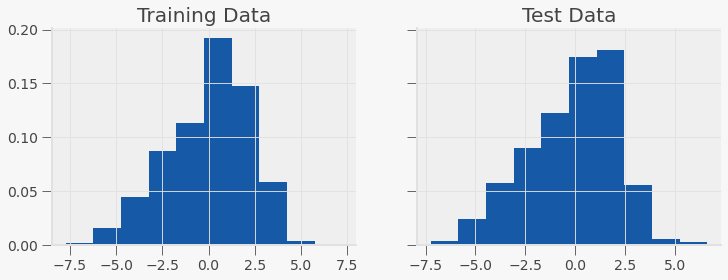

In [25]:
X_train, X_test, y_train, y_test = prep_data(
    df, ["priors_count"], ["age_cat", "race", "sex"], "decile_score"
)

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

yhat_train = lr_model.predict(X_train)
yhat_test = lr_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey="all")

ax[0].hist(yhat_train - y_train, density=True)
ax[0].set_title("Training Data")
ax[1].hist(yhat_test - y_test, density=True)
ax[1].set_title("Test Data")

The coefficients are listed below:

In [26]:
names = [
    "priors_count", "Less than 25", "25-45", "Greater than 45", "African-American",
    "Caucasian", "Hispanic", "Female", "Male"
]
for (_name, _coef) in zip(names, lr_model.coef_):
    print(_name, ": ", _coef)

priors_count :  0.2799923049684579
Less than 25 :  -0.10262755807946589
25-45 :  -1.7189018948181365
Greater than 45 :  1.8215294528975996
African-American :  0.6102522379830785
Caucasian :  -0.10156939689442401
Hispanic :  -0.5086828410886544
Female :  0.04293582427466183
Male :  -0.04293582427466186


What stands out to you about these coefficients?

````{admonition} Exercise
:name: app-rcd-dir1
See exercise 1 in the {ref}`exercise list <app-rcd-ex>`.
````

### Binary Probability Models

Binary probability models are used to model "all or nothing" outcomes,
like the occurrence of an event.

Their output is the probability that an event of interest occurs.

With this probability in hand, the researcher chooses an acceptable cutoff (perhaps 0.5)
above which the event is predicted to occur.

```{note}
Binary probability models can be thought of as a special case of
classification.

In classification, we are given a set of features and asked to predict
one of a finite number of discrete labels.

We will learn more about classification in an upcoming lecture!
```

In our example, we will be interested in how the COMPAS scores do at predicting recidivism and how
their ability to predict depends on race or sex.

To assist us in evaluating the performance of various models we will use a new
metric called the *confusion matrix*.

Scikit-learn knows how to compute this metric and also provides a good description
of what is computed.

Let's see what they have to say.

In [27]:
help(metrics.confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

In [28]:
def report_cm(mod, X_train, X_test, y_train, y_test):
     return dict(
         cm_train=metrics.confusion_matrix(y_train, mod.predict(X_train)),
         cm_test=metrics.confusion_matrix(y_test, mod.predict(X_test))
     )

We will start by using logistic regression using only `decile_score`
as a feature and then examine how the confusion matrices differ by
race and sex.

In [29]:
from patsy import dmatrices
groups = [
    "overall", "African-American", "Caucasian", "Hispanic", "Female", "Male"
]

ind = [
    "Portion_of_NoRecid_and_LowRisk", "Portion_of_Recid_and_LowRisk",
    "Portion_of_NoRecid_and_HighRisk", "Portion_of_Recid_and_HighRisk"
]

fmla = "two_year_recid ~ C(decile_score)"
y,X = dmatrices(fmla, df)
X_train, X_test, y_train, y_test, df_train, df_test = model_selection.train_test_split(
    X,y.reshape(-1),df, test_size=0.25, random_state=42
)


decile_mod = linear_model.LogisticRegression(solver="lbfgs").fit(X_train,y_train)

def cm_tables(pred, y, df):
    output = pd.DataFrame(index=ind, columns=groups)
    for group in groups:
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape, True)

        y_sub = y[subset]
        pred_sub = pred[subset]

        cm = metrics.confusion_matrix(y_sub, pred_sub)

        # Compute fraction for which the guess is correct
        total = cm.sum()
        vals = np.array(cm/total)
        output.loc[:, group] = vals.reshape(-1)


    def cond_probs(col, axis):
        d=int(np.sqrt(len(col)))
        pcm = np.array(col).reshape(d,d)
        pcm = pcm/pcm.sum(axis=axis, keepdims=True)
        return(pcm.reshape(-1))

    given_outcome = output.copy()
    given_outcome.index = ["P(LowRisk|NoRecid)","P(HighRisk|NoRecid)","P(LowRisk|Recid)","P(HighRisk|Recid)"]
    given_outcome=given_outcome.apply(lambda c: cond_probs(c,1))

    given_pred = output.copy()
    given_pred.index = ["P(NoRecid|LowRisk)","P(NoRecid|HighRisk)","P(Recid|LowRisk)","P(Recid|HighRisk)"]
    given_pred=given_pred.apply(lambda c: cond_probs(c,0))
    return(output,given_outcome, given_pred)

output, given_outcome, given_pred =cm_tables(decile_mod.predict(X_test),
                                             y_test, df_test)
output

,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.361815,0.263270,0.475000,0.522581,0.438040,0.342222
Portion_of_Recid_and_LowRisk,0.191514,0.230361,0.136667,0.167742,0.207493,0.187407
Portion_of_NoRecid_and_HighRisk,0.152033,0.140127,0.168333,0.161290,0.141210,0.154815
Portion_of_Recid_and_HighRisk,0.294638,0.366242,0.220000,0.148387,0.213256,0.315556


`output` contains information on the percent of true negatives, false negatives, false positives,
and true positives.

What do you see?

The joint probabilities (of prediction and outcome given race or sex) in the
above table are a bit hard to interpret.

Conditional probabilities can be easier to think about.

Let's look at the probability of outcomes given the prediction as well as race or sex.

In [30]:
given_pred

,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.704128,0.652632,0.738342,0.764151,0.756219,0.688525
P(NoRecid|HighRisk),0.393939,0.386121,0.383178,0.530612,0.493151,0.372607
P(Recid|LowRisk),0.295872,0.347368,0.261658,0.235849,0.243781,0.311475
P(Recid|HighRisk),0.606061,0.613879,0.616822,0.469388,0.506849,0.627393


As you can see, the distribution of outcomes conditional on predictions does
not vary too much with race.

Moreover, if anything, it discriminates in favor of African-Americans.

The algorithm does appear to overpredict recidivism for women compared
to men.

This is an important concern.

We will not discuss it too much though because (1) we will see below that
when fairness is looked at in another way, women are favored over men,
and (2) the company that produces COMPAS also produces a separate
questionnaire and risk score designed only for women.

### False Positive and Negative Rates

What if we flip this around and look at the distributions of
predictions conditional on outcomes?

Why look at these probabilities?

One reason is that in law, it's traditionally far
worse to punish innocents than let the guilty free. This idea goes at
least back to [1760 and Blackstone's ratio](https://en.wikipedia.org/wiki/Blackstone%27s_ratio).

> It is better that ten guilty persons escape than that one innocent
> suffer. -William Blackstone

Blackstone's ratio says that we should be particularly concerned about
P(HighRisk | NoRecid).

This probability is also called the false
positive rate.

In [31]:
given_outcome

,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.653887,0.533333,0.776567,0.757009,0.678571,0.646154
P(HighRisk|NoRecid),0.346113,0.466667,0.223433,0.242991,0.321429,0.353846
P(LowRisk|Recid),0.340369,0.276730,0.433476,0.520833,0.398374,0.329134
P(HighRisk|Recid),0.659631,0.723270,0.566524,0.479167,0.601626,0.670866


Now we see some large disparities by race in the false positive rate
(and false negative rate). This is one of the main findings of the Pro
Publica article.

In response to Pro Publica, Northpointe, the company that produces
COMPAS, argued that COMPAS is not biased because the probabilities of
outcomes conditional on predictions (like P(NoRecid|LowRisk)) are
approximately equal across races {cite}`dieterich2016`.

Following {cite}`kleinberg2017`, we will call a prediction algorithm with this
property  well-calibrated.

Being well-calibrated is one criteria for fairness of a prediction algorithm.

Pro Publica's critique focuses on a different criteria -- that the the
probability of predicted categories conditional on true outcomes
should be equal across groups (i.e. P(HighRisk|NoRecid) should be
equal across races).

{cite}`kleinberg2017` calls a prediction algorithm with this property balanced.

### Visualizing Calibration and Balance

We can get a slightly more detailed look at calibration and balance by
recognizing that prediction algorithms typically compute a predicted
probability, not just a discrete predicted outcome.

The predicted outcome will typically be assigned to the category with the highest
predicted probability.

We can examine calibration graphically by plotting the P(recidivism | predicted probability)

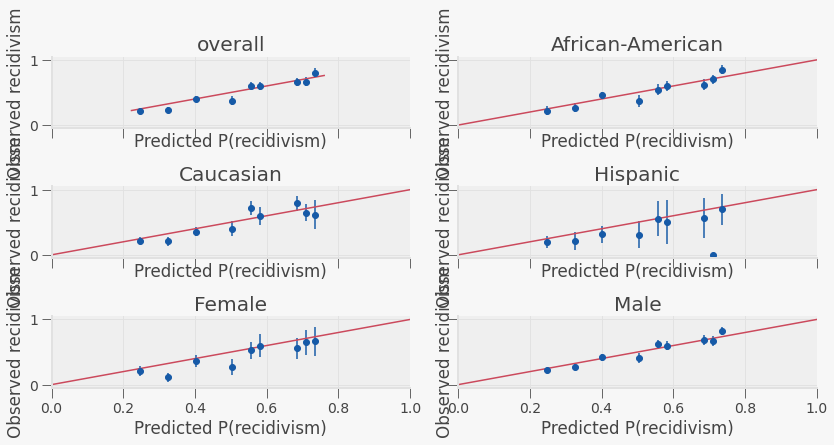

In [32]:
import scipy

def calibration_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(3,2, figsize=(12,6), sharey=True, sharex=True)
    for (g,group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape,True)
        _ax = ax[np.unravel_index(g, ax.shape)]
        y_sub = y[subset]
        pred_sub = pred[subset]
        mu, edges, n=scipy.stats.binned_statistic(pred_sub,y_sub,'mean',bins=bins)
        se, edges,n=scipy.stats.binned_statistic(pred_sub,y_sub,
                         lambda x: np.std(x)/np.sqrt(len(x)),bins=bins)
        midpts = (edges[0:-1]+edges[1:])/2
        _ax.errorbar(midpts, mu, yerr=1.64*se, fmt='o')
        _ax.set_title(group)
        _ax.set_ylabel("Observed recidivism")
        _ax.set_xlabel("Predicted P(recidivism)")
        x = np.linspace(*_ax.get_xlim())
        _ax.plot(x, x)
        _ax.set_xlim(0.0,1.0)
    fig.tight_layout()
    return(fig,ax)

calibration_plot(decile_mod.predict_proba(X_test)[:,1],
                 df_test["two_year_recid"],
                 df_test);

This figure is one way to visualize how well-calibrated these
predictions are.

The dots are binned averages of observed recidivism, conditional on
predicted recidivism being in some range.

The error bars represent a 90% confidence interval.

A perfectly calibrated prediction would have these dots all lie
along the 45 degree line.

For dots below the 45 degree line, the algorithm is overpredicting
recidivism.

````{admonition} Exercise
:name: app-rcd-dir2
See exercise 2 in the {ref}`exercise list <app-rcd-ex>`.
````

The algorithm appears fairly well-calibrated.

It does not seem to be making systematic errors in one direction based on any particular
race-- but it does appear to be systematic overprediction for females compared to males.

Now, let's create a figure to examine balance.

Balance is about the distribution of predictions conditional on outcomes,
so we will plot histograms of predicted probabilities conditional on realized
outcomes.

/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/share/miniconda3/envs/lecture-datascience/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

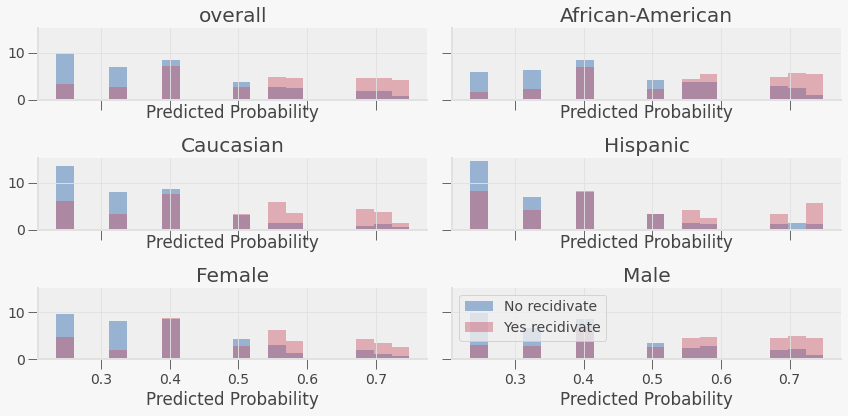

In [33]:
import seaborn as sns
def balance_hist_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(3,2, figsize=(12,6), sharey=True, sharex=True)
    for (g,group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
        else:
            subset=np.full(y.shape,True)
        _ax = ax[np.unravel_index(g, ax.shape)]
        y_sub = y[subset]
        pred_sub = pred[subset]
        sns.distplot(pred_sub[y_sub==0], hist=True, bins=bins, kde=False, ax=_ax,
                     label="No recidivate", norm_hist=True, axlabel="Predicted Probability")
        sns.distplot(pred_sub[y_sub==1], hist=True, bins=bins, kde=False, ax=_ax,
                     label="Yes recidivate", norm_hist=True, axlabel="Predicted Probability")
        _ax.set_title(group)

    plt.legend()
    fig.tight_layout()
    return(fig,ax)

balance_hist_plot(decile_mod.predict_proba(X_test)[:,1],
                  df_test["two_year_recid"],
                  df_test);

This figure is somewhat useful, but not for depicting balance
especially clearly, so let's try something else.

To get false positive and false negative rates, we must assign the predicted
probabilities to outcomes.

The most common choice would be to predict recidivism if the predicted
probability is greater than 0.5.

However, if we want to adjust the false positive and false negative rates, we
might want to choose some other threshold and predict recidivism if
the predicted probability exceeds this threshold.

Different thresholds will lead to different false negative and false
positive rates, so let's plot these rates as functions of the threshold.

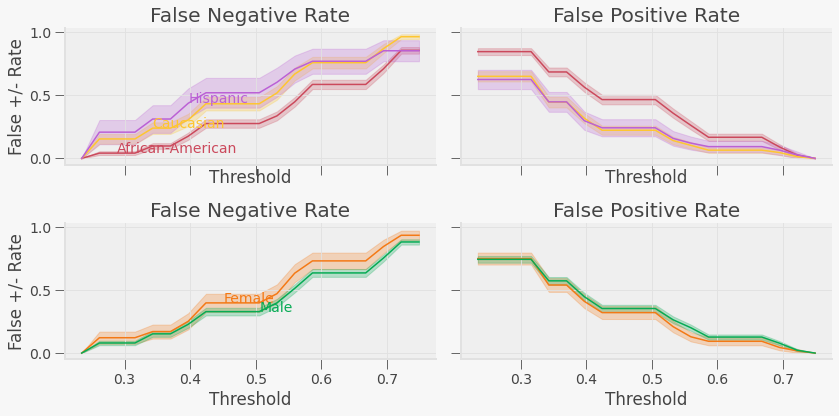

In [34]:
def balance_threshold_plot(pred, y, df, bins=20):
    fig,ax = plt.subplots(2,2, figsize=(12,6), sharey=True,
                          sharex=True)
    x = np.linspace(min(pred), max(pred), bins)
    # get colors defined by theme
    colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for (g, group) in enumerate(groups):
        if group in ["African-American", "Caucasian", "Hispanic"]:
            subset=(df.race==group)
            r = 0
        elif group in ["Female", "Male"]:
            subset=(df.sex==group)
            r = 1
        else:
            continue
        y_sub = y[subset]
        pred_sub = pred[subset]
        _ax = ax[r,0]
        fn = np.array([np.mean(pred_sub[y_sub==1]<xi) for xi in x])
        c1 = sum(y_sub==1)
        sen = np.sqrt(fn*(1-fn)/c1)
        fp = np.array([np.mean(pred_sub[y_sub==0]>xi) for xi in x])
        c0 = sum(y_sub==0)
        sep = np.sqrt(fp*(1-fp)/c0)
        p=_ax.plot(x, fn, color=colors[g])
        _ax.fill_between(x, fn-1.64*sen, fn+1.64*sen, alpha=0.25, color=colors[g])
        _ax.annotate(group, (x[bins//7*g], fn[bins//7*g]), color=colors[g])
        _ax.set_ylabel("False +/- Rate")
        _ax.set_xlabel("Threshold")
        _ax.set_title("False Negative Rate")

        _ax = ax[r,1]
        p=_ax.plot(x, fp, color=colors[g])
        _ax.fill_between(x, fp-1.64*sep, fp+1.64*sep, alpha=0.25, color=colors[g])
        _ax.set_xlabel("Threshold")
        _ax.set_title("False Positive Rate")

    fig.tight_layout()
    return(fig,ax)

balance_threshold_plot(decile_mod.predict_proba(X_test)[:,1],
                       df_test["two_year_recid"],
                       df_test);

From this, we can more easily see the balance problem --- regardless
of which threshold we choose, African-Americans will have a higher
false positive rate than Caucasians.

We have seen that COMPAS scores are well-calibrated conditional on
race, but not balanced.

Can we create an alternative prediction that is both well-calibrated and balanced?

### Creating an Alternative Prediction

As a starting exercise, let's predict recidivism using the variables
in this dataset other than race and COMPAS score.

Almost all variables in this data are categorical.

Any function of categorical variables can be represented as a linear
function of indicator variables and their interactions.

Given that linearity in indicators does not impose any substantiative restriction
here, a penalized linear model like lasso seems like a good choice for prediction.

To keep the computation time reasonable, we do not include all interaction
and indicator terms here.

To ensure that predicted probabilities are between 0 and 1, we fit a logistic
regression with an $\ell-1$ penalty.

In [35]:
from sklearn import model_selection, linear_model
from patsy import dmatrices

# charge_desc has many values with one observations, we will
# combine these descriptions into a single "other." This could
# be improved upon by looking at the text of descriptions and
# combining.
df.c_charge_desc = df.c_charge_desc.fillna("")
df["charge_cat"] = df.c_charge_desc
cnt = df.c_charge_desc.value_counts()[df.c_charge_desc]
cnt.index = df.index
df.loc[cnt<10,"charge_cat"] = "other"
df.charge_cat = df.charge_cat.astype('category')
df.sex = df.sex.astype('category')


fmla = "two_year_recid ~ sex*(age + juv_fel_count + juv_misd_count + juv_other_count + C(priors_count) + c_charge_degree + charge_cat)"

y,X = dmatrices(fmla, df)
print("There are {} features".format(X.shape[1]))
X_train, X_test, y_train, y_test, df_train, df_test = model_selection.train_test_split(
    X,pd.Series(y.reshape(-1),index=df.index),df, test_size=0.25, random_state=42
)

lasso_mod=linear_model.LogisticRegressionCV(cv=5,verbose=True,
                                            Cs=10, penalty='l1',
                                            max_iter=100,
                                            scoring="neg_log_loss",
                                            solver="liblinear").fit(X_train, y_train)

There are 260 features
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear]

[LibLinear]

[LibLinear]

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[LibLinear]

[LibLinear]

[LibLinear]

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[LibLinear]

[LibLinear]

[LibLinear]

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[LibLinear][LibLinear]

[LibLinear]

[LibLinear]

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[LibLinear]

[LibLinear]

[LibLinear]

[LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Let's look at the regularization parameter chosen and the non-zero coefficients.

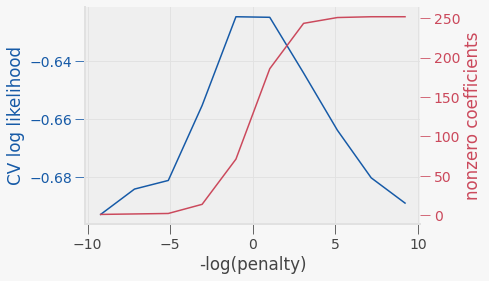

In [36]:
# plots illustrating regularization parameter choice
scores=lasso_mod.scores_[1.0].mean(axis=0)
logpenalties=np.log(lasso_mod.Cs_)
nnonzero=(np.abs(lasso_mod.coefs_paths_[1.0])>1e-6).sum(axis=2).mean(axis=0)
colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax1 = plt.subplots()
ax1.plot(logpenalties,scores, color=colors[0])
ax1.set_ylabel("CV log likelihood", color=colors[0])
ax1.set_xlabel("-log(penalty)")
ax1.tick_params('y', colors=colors[0])
ax2 = ax1.twinx()
ax2.plot(logpenalties,nnonzero, color=colors[1])
ax2.set_ylabel("nonzero coefficients", color=colors[1])
ax2.tick_params('y', colors=colors[1])
ax2.grid(b=None);

Let's also look at the nonzero coefficients. We should be careful
about interpreting these, since relatively strong assumptions are
needed for lasso to produce consistent coefficient estimates.

```{note}
Lasso gives accurate predictions under weaker assumptions than needed for
consistent coefficient estimates.
```

In [37]:
# table of nonzero coefficients
coef = pd.DataFrame(index = X.design_info.column_names, columns=["Value"])
coef.Value = np.transpose(lasso_mod.coef_)
print(sum(np.abs(coef.Value)>1.0e-8))
with pd.option_context('display.max_rows', None):
    display(coef[np.abs(coef.Value)>1.0e-8])

82


,Value
Intercept,0.023670
sex[T.Male],0.724445
C(priors_count)[T.2],0.325194
C(priors_count)[T.3],0.612255
C(priors_count)[T.4],0.749700
C(priors_count)[T.5],0.732786
C(priors_count)[T.6],0.792298
C(priors_count)[T.7],1.032677
C(priors_count)[T.8],1.322570
C(priors_count)[T.9],1.286935


Now, let's look at calibration and balance using similar tables and
figures as we did above.

,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.411903,0.332272,0.490000,0.593548,0.596542,0.364444
Portion_of_Recid_and_LowRisk,0.141426,0.161359,0.121667,0.096774,0.048991,0.165185
Portion_of_NoRecid_and_HighRisk,0.190925,0.182590,0.201667,0.200000,0.250720,0.175556
Portion_of_Recid_and_HighRisk,0.255745,0.323779,0.186667,0.109677,0.103746,0.294815


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.683284,0.645361,0.708434,0.747967,0.704082,0.674897
P(NoRecid|HighRisk),0.356083,0.332604,0.394595,0.468750,0.320755,0.359098
P(Recid|LowRisk),0.316716,0.354639,0.291566,0.252033,0.295918,0.325103
P(Recid|HighRisk),0.643917,0.667396,0.605405,0.531250,0.679245,0.640902


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.744409,0.673118,0.801090,0.859813,0.924107,0.688112
P(HighRisk|NoRecid),0.255591,0.326882,0.198910,0.140187,0.075893,0.311888
P(LowRisk|Recid),0.427441,0.360587,0.519313,0.645833,0.707317,0.373228
P(HighRisk|Recid),0.572559,0.639413,0.480687,0.354167,0.292683,0.626772


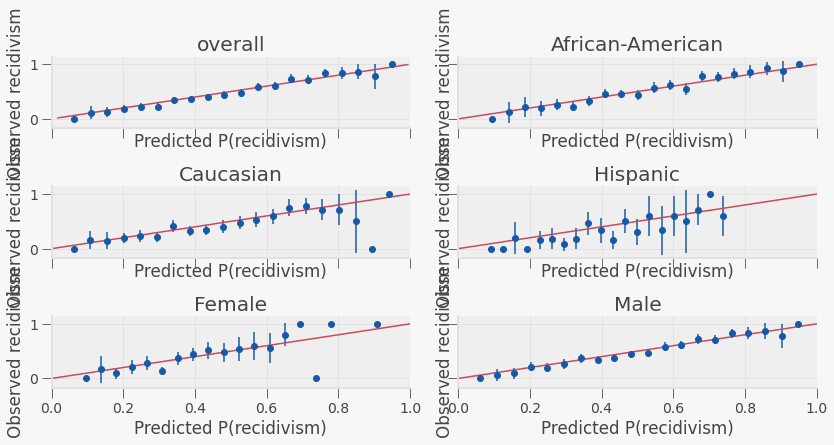

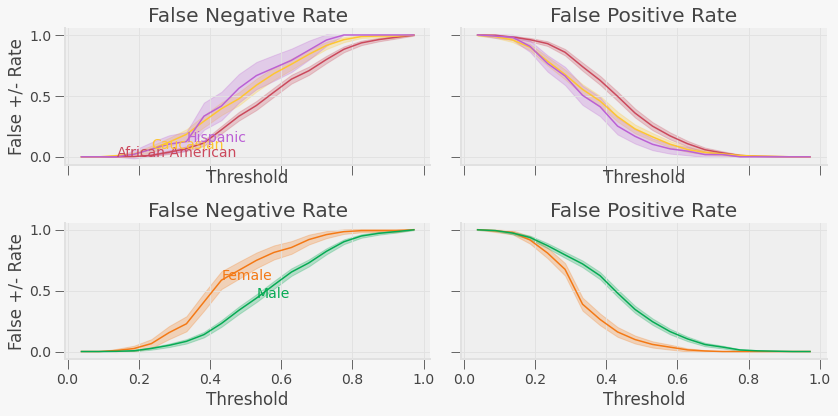

In [38]:
output, given_outcome, given_pred =cm_tables(
    lasso_mod.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)

calibration_plot(lasso_mod.predict_proba(X_test)[:,1],y_test, df_test)
balance_threshold_plot(lasso_mod.predict_proba(X_test)[:,1],y_test, df_test);

As with COMPAS score, our predictions are well-calibrated, but the
false negative and false positive rates are not well balanced across
racial groups.

````{admonition} Exercise
:name: app-rcd-dir3
See exercise 3 in the {ref}`exercise list <app-rcd-ex>`.
````

### Regularizing to Maximize Balance

Trying to improve balance by ad-hoc modifications will be
difficult.

Let's try to do it more systematically.

We usually select models and choose regularization to minimize prediction errors.

We can just as well select models and regularization parameters to optimize
some other criteria.

Let's choose the regularization parameter for lasso to maximize balance.

In [39]:
# define a custom CV criteria to maximize
def balance_scorer(y_true, prob, df, weights):
    ind = df.isin(y_true.index)
    df_cv = df.loc[y_true.index.values,:]
    b = df_cv.race=="African-American"
    w = df_cv.race=="Caucasian"
    y_pred = 1*(prob>0.5)
    fprb = np.mean(y_pred[(y_true==0) & b])
    fprw = np.mean(y_pred[(y_true==0) & w])
    fnrb = np.mean(y_pred[(y_true==1) & b]==0)
    fnrw = np.mean(y_pred[(y_true==1) & w]==0)
    return(-weights[0]*(fprb-fprw)**2 +
           -weights[1]*(fnrb-fnrw)**2 +
           -weights[2]*(metrics.log_loss(y_true, prob, normalize=True)))

score_params = {"df": df_train, "weights": [10.0, 1.0, 0.0]}
scorer = metrics.make_scorer(balance_scorer, **score_params, needs_proba=True)
grid_cv = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(penalty="l1",
                                              max_iter=100,
                                              solver="liblinear"),
    scoring=scorer,
    cv=5,
    param_grid={'C':
    np.exp(np.linspace(-10,10,10))},
    return_train_score=True,
    verbose=True,
    refit=True,)

balance_mod=grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


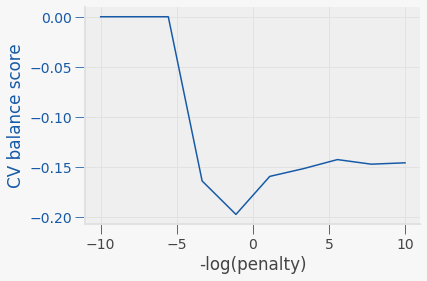

In [40]:
# plots illustrating regularization parameter choice
def grid_cv_plot(mod, ylabel=""):
    scores=mod.cv_results_["mean_test_score"]
    Cdict=mod.cv_results_["params"]
    logpenalties=np.log([d['C'] for d in Cdict])
    colors=plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax1 = plt.subplots()
    ax1.plot(logpenalties,scores, color=colors[0])
    ax1.set_ylabel(ylabel, color=colors[0])
    ax1.set_xlabel("-log(penalty)")
    ax1.tick_params('y', colors=colors[0]);
grid_cv_plot(balance_mod,"CV balance score")

We can be perfectly balanced by making the regularization parameter
very large.

Unfortunately, this makes all the predictions identical, so these predictions
are not so useful.

In [41]:
output, given_outcome, given_pred =cm_tables(
    balance_mod.best_estimator_.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)

<ipython-input-29-a4751be75b73>:44: RuntimeWarning: invalid value encountered in true_divide
  pcm = pcm/pcm.sum(axis=axis, keepdims=True)


,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.553329,0.493631,0.611667,0.690323,0.645533,0.52963
Portion_of_Recid_and_LowRisk,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Portion_of_NoRecid_and_HighRisk,0.446671,0.506369,0.388333,0.309677,0.354467,0.47037
Portion_of_Recid_and_HighRisk,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.553329,0.493631,0.611667,0.690323,0.645533,0.52963
P(NoRecid|HighRisk),NaN,NaN,NaN,NaN,NaN,NaN
P(Recid|LowRisk),0.446671,0.506369,0.388333,0.309677,0.354467,0.47037
P(Recid|HighRisk),NaN,NaN,NaN,NaN,NaN,NaN


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),1.0,1.0,1.0,1.0,1.0,1.0
P(HighRisk|NoRecid),0.0,0.0,0.0,0.0,0.0,0.0
P(LowRisk|Recid),1.0,1.0,1.0,1.0,1.0,1.0
P(HighRisk|Recid),0.0,0.0,0.0,0.0,0.0,0.0


What if we change our CV scoring function to care about both
prediction and balance?

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,overall,African-American,Caucasian,Hispanic,Female,Male
Portion_of_NoRecid_and_LowRisk,0.405421,0.328025,0.483333,0.574194,0.561960,0.365185
Portion_of_Recid_and_LowRisk,0.147908,0.165605,0.128333,0.116129,0.083573,0.164444
Portion_of_NoRecid_and_HighRisk,0.189747,0.181529,0.200000,0.200000,0.239193,0.177037
Portion_of_Recid_and_HighRisk,0.256924,0.324841,0.188333,0.109677,0.115274,0.293333


,overall,African-American,Caucasian,Hispanic,Female,Male
P(NoRecid|LowRisk),0.681188,0.643750,0.707317,0.741667,0.701439,0.673497
P(NoRecid|HighRisk),0.365357,0.337662,0.405263,0.514286,0.420290,0.359223
P(Recid|LowRisk),0.318812,0.356250,0.292683,0.258333,0.298561,0.326503
P(Recid|HighRisk),0.634643,0.662338,0.594737,0.485714,0.579710,0.640777


,overall,African-American,Caucasian,Hispanic,Female,Male
P(LowRisk|NoRecid),0.732694,0.664516,0.790191,0.831776,0.870536,0.689510
P(HighRisk|NoRecid),0.267306,0.335484,0.209809,0.168224,0.129464,0.310490
P(LowRisk|Recid),0.424802,0.358491,0.515021,0.645833,0.674797,0.376378
P(HighRisk|Recid),0.575198,0.641509,0.484979,0.354167,0.325203,0.623622


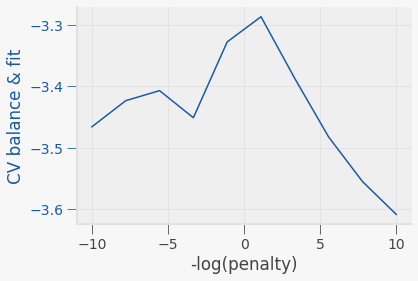

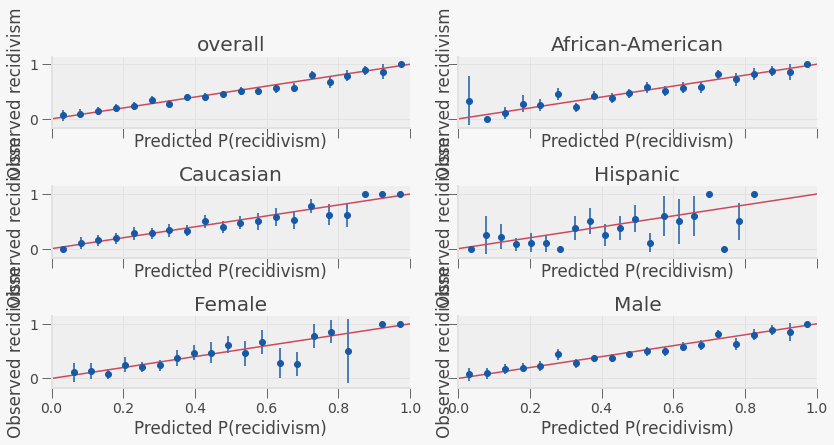

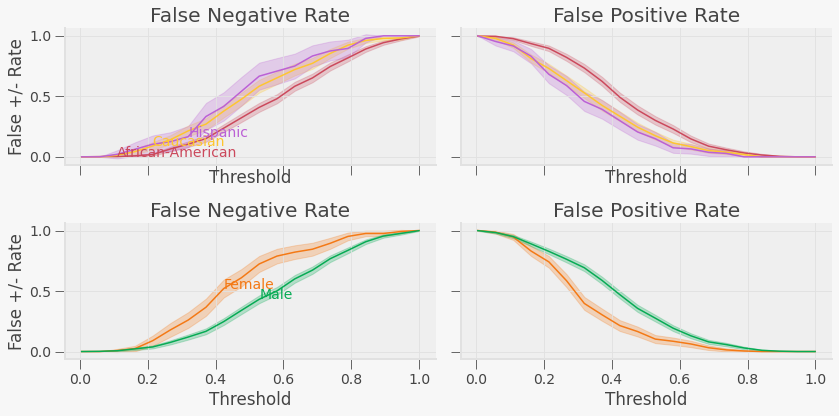

In [42]:
score_params = {"df": df_train, "weights": [10.0, 1.0, 5.0]}
grid_cv.set_params(scoring=metrics.make_scorer(balance_scorer, **score_params, needs_proba=True))
bf_mod=grid_cv.fit(X_train,y_train)
grid_cv_plot(bf_mod,"CV balance & fit")

output, given_outcome, given_pred =cm_tables(
    bf_mod.best_estimator_.predict(X_test),
    y_test,
    df_test
)
display(output)
display(given_pred)
display(given_outcome)
calibration_plot(bf_mod.best_estimator_.predict_proba(X_test)[:,1],y_test, df_test)
balance_threshold_plot(bf_mod.best_estimator_.predict_proba(X_test)[:,1],y_test, df_test);

````{admonition} Exercise
:name: app-rcd-dir4
See exercise 4 in the {ref}`exercise list <app-rcd-ex>`.
````

### Tradeoffs are Inevitable

We could try to tweak our predictions further to improve
balance.

However, motivated in part by this COMPAS example, {cite}`kleinberg2017` proved
that it is impossible for any prediction algorithm to be both perfectly
balanced and well-calibrated.

Improvements in balance necessarily make calibration worse.

## References

```{bibliography} applications.bib
:labelprefix: recid
```

(app-rcd-ex)=
## Exercises

### Exercise 1

Can you develop a model that performs better at mimicking their risk scores?

({ref}`back to text <app-rcd-dir1>`)

### Exercise 2

We made our calibration plot using a held-out test sample. What
do you think would happen if made the calibration plot using the
training sample? Check and see.

In [43]:
# Create calibration plot using training data

({ref}`back to text <app-rcd-dir2>`)

### Exercise 3

Try to improve balance and/or calibration by creating an
alternative prediction.

In [44]:
# Fit your prediction model and plot calibration and balance

({ref}`back to text <app-rcd-dir3>`)

### Exercise 4

Modify the cross-validation scoring function to see how it affects
calibration and balance.

({ref}`back to text <app-rcd-dir4>`)